<a href="https://colab.research.google.com/github/Teganmosi/Tweets-classification/blob/main/nlp_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-53fbc94a-6c5a-3062-d3b3-2befda4d2f7e)


In [3]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-26 23:50:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-26 23:50:52 (110 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [5]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-06-26 23:50:55--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K   700KB/s    in 0.8s    

2023-06-26 23:50:56 (700 KB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
%matplotlib inline

In [7]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
train_df_shuffled = train_df.sample(frac = 1, random_state = 42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [9]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [10]:
print(f'Total training samples: {len(train_df)}')
print(f'Total Test samples: {len(test_df)}')

Total training samples: 7613
Total Test samples: 3263


In [11]:
# to visualize some examples in the training set
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[['text', 'target']][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f'Target:{target}', '(real disaster)' if target > 0 else '(not real disaster)')
  print(f'Text:\n{text}\n')
  print('---\n')


Target:1 (real disaster)
Text:
Oregon's biggest wildfire slows growth http://t.co/P0GoS5URXG via @katunews

---

Target:1 (real disaster)
Text:
New #photo Oak in a snowstorm http://t.co/HK9Yf72OVA taken in #winter on the #SouthDowns #Hampshire #photography #art #tree #treeporn

---

Target:1 (real disaster)
Text:
CLIMATE CONSEQUENCES: U.S. Forest Service Says Spending More Than Half Of Budget On Fires http://t.co/k0QtL8aODH http://t.co/zQBXe7x9Y7

---

Target:0 (not real disaster)
Text:
#InsaneLimits #plugin enabled  @'    =TPS= | TDM | 400T | HARDCORE | LOCKER | WEAPON RULES' using 3 limits

---

Target:0 (not real disaster)
Text:
(OFFICIAL VID) &gt; #DoubleCups &gt;&gt; https://t.co/lfKMTZaEkk &gt;&gt; @TrubGME Prod @THISIZBWRIGHT &gt;&gt; #ARMAGEDDON                 .

---



In [12]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [13]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [14]:
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

In [15]:
from numpy.random import standard_t
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens = None,
                                    standardize = 'lower_and_strip_punctuation',
                                    split = 'whitespace',
                                    ngrams = None,
                                    output_mode = 'int',
                                    output_sequence_length = None)

In [16]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [17]:
max_vocab_length = 10000
max_length = 15

text_vectoriser = TextVectorization(max_tokens = max_vocab_length,
                  standardize = 'lower_and_strip_punctuation',

                  output_mode = 'int',
                  output_sequence_length = max_length)

In [18]:
# Fit the text vectorizer to the training text
text_vectoriser.adapt(train_sentences)

In [19]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectoriser([random_sentence])

Original text:
Save your riches in heaven where they will never decrease because no thief can gets them and no moth can destroy them. ??      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 328,   33, 9089,    4, 2962,  221,   64,   38,  192,    1,  152,
          40, 4430,   71,  742]])>

In [20]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectoriser.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [21]:
from tensorflow.keras import layers
tf.random.set_seed(42)

embedding = layers.Embedding(input_dim = max_vocab_length,
                output_dim = 128,
                embeddings_initializer = 'uniform',
                input_length = max_length,
                name = 'embedding_1')

embedding

In [22]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectoriser([random_sentence]))
sample_embed

Original text:
Water now tops the charts for highest global risk in terms of devastationÛ_ ahead of nuclear war or a global pandemic http://t.co/nbcvbSO9nm      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-4.8264183e-02, -4.6259951e-02,  3.0591343e-02, ...,
          3.0208379e-05, -1.9246256e-02,  6.5665729e-03],
        [ 9.6905120e-03,  4.1514229e-02,  7.1983337e-03, ...,
          7.9455599e-03,  1.6435813e-02,  3.4718741e-02],
        [ 1.8977974e-02,  2.5386784e-02, -3.1303719e-02, ...,
         -1.3201237e-02,  3.2862909e-03, -2.4591481e-02],
        ...,
        [-2.3396004e-02,  4.7619231e-03, -5.9582219e-03, ...,
         -4.8543226e-02,  3.1515211e-04, -4.3338358e-02],
        [ 6.2815174e-03,  5.8364384e-03, -4.8782256e-02, ...,
          1.4327299e-02, -1.8167339e-02, -2.8937494e-02],
        [-7.3442608e-04, -6.7363605e-03, -1.8417239e-03, ...,
          6.1497204e-03, -2.7653623e-02,  4.7221188e-02]]], dtype=float32)>

In [23]:
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-4.8264183e-02, -4.6259951e-02,  3.0591343e-02, -2.5179410e-02,
       -9.0339407e-03, -3.6565937e-02,  1.5808534e-02, -1.0090135e-02,
        4.6650615e-02,  4.5158874e-02, -2.2322213e-02, -4.6925616e-02,
       -3.1410344e-03,  2.1011446e-02, -2.2518147e-02, -2.5079323e-02,
       -1.7699040e-02, -2.3056710e-02,  2.8313641e-02, -1.9903708e-02,
        4.7688853e-02, -2.5523901e-02,  4.5033861e-02, -3.6435090e-02,
        1.3441291e-02,  4.6507727e-02, -1.9934202e-02,  3.3894684e-02,
       -1.0066390e-02, -3.9995089e-03, -1.6579449e-02,  3.9368574e-02,
       -4.1445065e-02, -3.9944209e-02,  4.1704662e-03,  4.3836083e-02,
        4.9700204e-02,  1.8940199e-02, -2.3855567e-02,  2.1127257e-02,
        4.1786049e-02, -2.9433919e-02, -3.6476541e-02,  3.6458883e-02,
        2.6873160e-02, -1.5097309e-02,  3.4270994e-03, -1.9135976e-02,
       -2.3009373e-02, -2.8657531e-02, -1.0639809e-02,  4.3323040e-03,
        2.0431545e-02,  1.130

In [24]:
from math import pi
#Creating the baseline model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('cif', MultinomialNB())
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('cif', MultinomialNB())])

In [25]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f'Our baseline model achieves an accuracy of :{baseline_score*100:.2f}%')

Our baseline model achieves an accuracy of :79.27%


In [26]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [27]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [28]:
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [29]:
from tensorflow.keras import layers
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [30]:
inputs = layers.Input(shape = (1,), dtype = 'string')
x = text_vectoriser(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_1 =  tf.keras.Model(inputs, outputs, name = 'model_1_dense')

In [31]:
model_1.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [32]:
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR,
                                                                       experiment_name = 'simple_dense')])

Saving TensorBoard log files to: model_logs/simple_dense/20230626-235101
Epoch 1/5
215/215 [==============================] - 20s 67ms/step - loss: 0.6099 - accuracy: 0.6948 - val_loss: 0.5367 - val_accuracy: 0.7520
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4414 - accuracy: 0.8186 - val_loss: 0.4698 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3466 - accuracy: 0.8618 - val_loss: 0.4595 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2851 - accuracy: 0.8921 - val_loss: 0.4645 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2382 - accuracy: 0.9126 - val_loss: 0.4770 - val_accuracy: 0.7861


In [33]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4770 - accuracy: 0.7861


[0.47697216272354126, 0.7860892415046692]

In [34]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[-0.00280103, -0.01174677, -0.00719693, ...,  0.02227514,
         -0.00020883, -0.01541615],
        [-0.0290158 , -0.00175787, -0.01143129, ..., -0.04249552,
          0.0061936 , -0.03738135],
        [ 0.02231692, -0.00796011, -0.03841631, ..., -0.0154973 ,
         -0.02460976, -0.00111507],
        ...,
        [ 0.02114477, -0.04307038,  0.04585954, ..., -0.02861632,
          0.0357804 , -0.04215118],
        [-0.0148837 , -0.04568959, -0.04474613, ...,  0.06692131,
          0.04207874, -0.00383338],
        [-0.1044965 , -0.03222367, -0.02758856, ...,  0.08058511,
          0.07195915,  0.07804321]], dtype=float32)>]

In [35]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [36]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:20]

24/24 [==============================] - 0s 2ms/step


array([[0.42130238],
       [0.74605155],
       [0.9976011 ],
       [0.1129438 ],
       [0.10510686],
       [0.9363017 ],
       [0.9122814 ],
       [0.99290496],
       [0.96904176],
       [0.26845014],
       [0.12554832],
       [0.70057863],
       [0.05579889],
       [0.22009988],
       [0.00533893],
       [0.16299984],
       [0.02627942],
       [0.10658804],
       [0.24544744],
       [0.5528888 ]], dtype=float32)

In [37]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))

In [38]:
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [39]:
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred = model_1_preds)

model_1_results

{'accuracy': 78.60892388451444,
 'precision': 0.7903277546022673,
 'recall': 0.7860892388451444,
 'f1': 0.7832971347503846}

In [40]:
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [41]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.61, Difference: -0.66
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


In [42]:
words_in_vocab = text_vectoriser.get_vocabulary()
len(words_in_vocab), words_in_vocab[:20]

(10000,
 ['',
  '[UNK]',
  'the',
  'a',
  'in',
  'to',
  'of',
  'and',
  'i',
  'is',
  'for',
  'on',
  'you',
  'my',
  'with',
  'it',
  'that',
  'at',
  'by',
  'this'])

In [43]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [44]:
# Get the weight matrix of embedding layer
# (these are the numerical patterns between the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [45]:
#Using RNN
tf.random.set_seed(42)
model_2_embedding = layers.Embedding(input_dim = max_vocab_length,
                                     output_dim = 128,
                                     embeddings_initializer = 'uniform',
                                     input_length = max_length,
                                     name = 'embedding_2')

#creating LSTM model
inputs = layers.Input(shape = (1,), dtype = 'string')
x = text_vectoriser(inputs)
x = model_2_embedding(x)
print(x.shape)
x = layers.LSTM(64)(x)
print(x.shape)

(None, 15, 128)
(None, 64)


In [46]:
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [47]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [48]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [49]:
model_2.fit(train_sentences,
          train_labels,
          epochs = 5,
          validation_data = (val_sentences, val_labels),
          callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                   'LSTM')])

Saving TensorBoard log files to: model_logs/LSTM/20230626-235132
Epoch 1/5
215/215 [==============================] - 18s 67ms/step - loss: 0.5082 - accuracy: 0.7466 - val_loss: 0.4526 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.3142 - accuracy: 0.8729 - val_loss: 0.5146 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2163 - accuracy: 0.9174 - val_loss: 0.5944 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1500 - accuracy: 0.9458 - val_loss: 0.6141 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1057 - accuracy: 0.9585 - val_loss: 0.7684 - val_accuracy: 0.7703


In [50]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1),
 array([[0.00984842],
        [0.77781934],
        [0.99806947],
        [0.08208381],
        [0.00358237],
        [0.99763095],
        [0.76005715],
        [0.9992766 ],
        [0.99817944],
        [0.28882375]], dtype=float32))

In [51]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [52]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.03412073490814,
 'precision': 0.7726339681635592,
 'recall': 0.7703412073490814,
 'f1': 0.7679241301282296}

In [53]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 77.03, Difference: -2.23
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


In [54]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectoriser(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [55]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [56]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20230626-235200
Epoch 1/5
215/215 [==============================] - 13s 50ms/step - loss: 0.5214 - accuracy: 0.7327 - val_loss: 0.4559 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3179 - accuracy: 0.8705 - val_loss: 0.4907 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.2180 - accuracy: 0.9174 - val_loss: 0.5576 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1564 - accuracy: 0.9450 - val_loss: 0.6137 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1186 - accuracy: 0.9599 - val_loss: 0.6072 - val_accuracy: 0.7703


In [57]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1),
 array([[0.32132018],
        [0.9044698 ],
        [0.99712926],
        [0.13290918],
        [0.01705821],
        [0.9891453 ],
        [0.69820666],
        [0.9971752 ],
        [0.99655354],
        [0.61251307]], dtype=float32))

In [58]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [59]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.03412073490814,
 'precision': 0.7701208199177533,
 'recall': 0.7703412073490814,
 'f1': 0.7695203715374298}

In [60]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 77.03, Difference: -2.23
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


In [61]:
#USING BIDIRECTIONAL MODEL

# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectoriser(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [62]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [63]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [64]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20230626-235226
Epoch 1/5
215/215 [==============================] - 18s 62ms/step - loss: 0.5082 - accuracy: 0.7478 - val_loss: 0.4585 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3137 - accuracy: 0.8708 - val_loss: 0.5171 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2123 - accuracy: 0.9188 - val_loss: 0.5555 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1448 - accuracy: 0.9511 - val_loss: 0.6546 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1049 - accuracy: 0.9634 - val_loss: 0.6982 - val_accuracy: 0.7638


In [65]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[0.05421168],
       [0.7929743 ],
       [0.9993049 ],
       [0.1457132 ],
       [0.00682802],
       [0.996363  ],
       [0.9619178 ],
       [0.999653  ],
       [0.9995789 ],
       [0.19868967]], dtype=float32)

In [66]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [67]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 76.37795275590551,
 'precision': 0.7634711836373635,
 'recall': 0.7637795275590551,
 'f1': 0.7629812681164898}

In [68]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 76.38, Difference: -2.89
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.02


In [69]:
#USING Conv1D

# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectoriser(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 1)              

In [70]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20230626-235256
Epoch 1/5
215/215 [==============================] - 16s 48ms/step - loss: 0.5677 - accuracy: 0.7165 - val_loss: 0.4704 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3440 - accuracy: 0.8612 - val_loss: 0.4674 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2165 - accuracy: 0.9210 - val_loss: 0.5283 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1415 - accuracy: 0.9517 - val_loss: 0.5945 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0977 - accuracy: 0.9667 - val_loss: 0.6525 - val_accuracy: 0.7848


In [71]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.6583138 ],
       [0.8215733 ],
       [0.9995128 ],
       [0.05162894],
       [0.0028948 ],
       [0.997104  ],
       [0.9731511 ],
       [0.99749374],
       [0.99980325],
       [0.2841605 ]], dtype=float32)

In [72]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [73]:
# Calculate model_5 evaluation metrics
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 78.4776902887139,
 'precision': 0.7873574987198574,
 'recall': 0.7847769028871391,
 'f1': 0.7825760559664451}

In [74]:
# Compare model_5 results to baseline
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 78.48, Difference: -0.79
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


In [75]:
#using TensorFlow Hub Pretrained Sentence Encoder
import tensorflow_hub as hub

# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [76]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [77]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [78]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230626-235409
Epoch 1/5
215/215 [==============================] - 7s 14ms/step - loss: 0.5047 - accuracy: 0.7881 - val_loss: 0.4485 - val_accuracy: 0.8018
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.4154 - accuracy: 0.8139 - val_loss: 0.4380 - val_accuracy: 0.8110
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4010 - accuracy: 0.8215 - val_loss: 0.4341 - val_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3940 - accuracy: 0.8251 - val_loss: 0.4296 - val_accuracy: 0.8136
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3880 - accuracy: 0.8283 - val_loss: 0.4308 - val_accuracy: 0.8163


In [79]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.14863448],
       [0.75285834],
       [0.98317796],
       [0.18335587],
       [0.7295355 ],
       [0.6936247 ],
       [0.9792875 ],
       [0.97354895],
       [0.9168089 ],
       [0.08995807]], dtype=float32)

In [80]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [81]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.8187546712946793,
 'recall': 0.8162729658792651,
 'f1': 0.8147089025083661}

In [82]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.63, Difference: 2.36
Baseline precision: 0.81, New precision: 0.82, Difference: 0.01
Baseline recall: 0.79, New recall: 0.82, Difference: 0.02
Baseline f1: 0.79, New f1: 0.81, Difference: 0.03


In [83]:
# TensorFlow Hub Pretrained Sentence Encoder 10% of the training data

train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

In [84]:
# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [85]:
# Check the number of targets in our subset of data
# (this should be close to the distribution of labels in the original train_labels)
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
dtype: int64

In [86]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [87]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20230626-235753
Epoch 1/5
22/22 [==============================] - 5s 45ms/step - loss: 0.6649 - accuracy: 0.7114 - val_loss: 0.6434 - val_accuracy: 0.6969
Epoch 2/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5874 - accuracy: 0.8105 - val_loss: 0.5835 - val_accuracy: 0.7441
Epoch 3/5
22/22 [==============================] - 0s 21ms/step - loss: 0.5075 - accuracy: 0.8294 - val_loss: 0.5300 - val_accuracy: 0.7651
Epoch 4/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4440 - accuracy: 0.8440 - val_loss: 0.5014 - val_accuracy: 0.7651
Epoch 5/5
22/22 [==============================] - 0s 22ms/step - loss: 0.4026 - accuracy: 0.8426 - val_loss: 0.4864 - val_accuracy: 0.7743


In [88]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 17ms/step


array([[0.25055265],
       [0.8129991 ],
       [0.90781987],
       [0.31078324],
       [0.5761831 ],
       [0.84657454],
       [0.8086975 ],
       [0.86853033],
       [0.8376893 ],
       [0.12234986]], dtype=float32)

In [89]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [90]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.42782152230971,
 'precision': 0.779472762048361,
 'recall': 0.7742782152230971,
 'f1': 0.770786705353106}

In [91]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 77.43, Difference: -1.84
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


In [92]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.608924,0.790328,0.786089,0.783297
lstm,77.034121,0.772634,0.770341,0.767924
gru,77.034121,0.770121,0.770341,0.769520
bidirectional,76.377953,0.763471,0.763780,0.762981
conv1d,78.477690,0.787357,0.784777,0.782576
tf_hub_sentence_encoder,81.627297,0.818755,0.816273,0.814709
tf_hub_10_percent_data,77.427822,0.779473,0.774278,0.770787


In [93]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

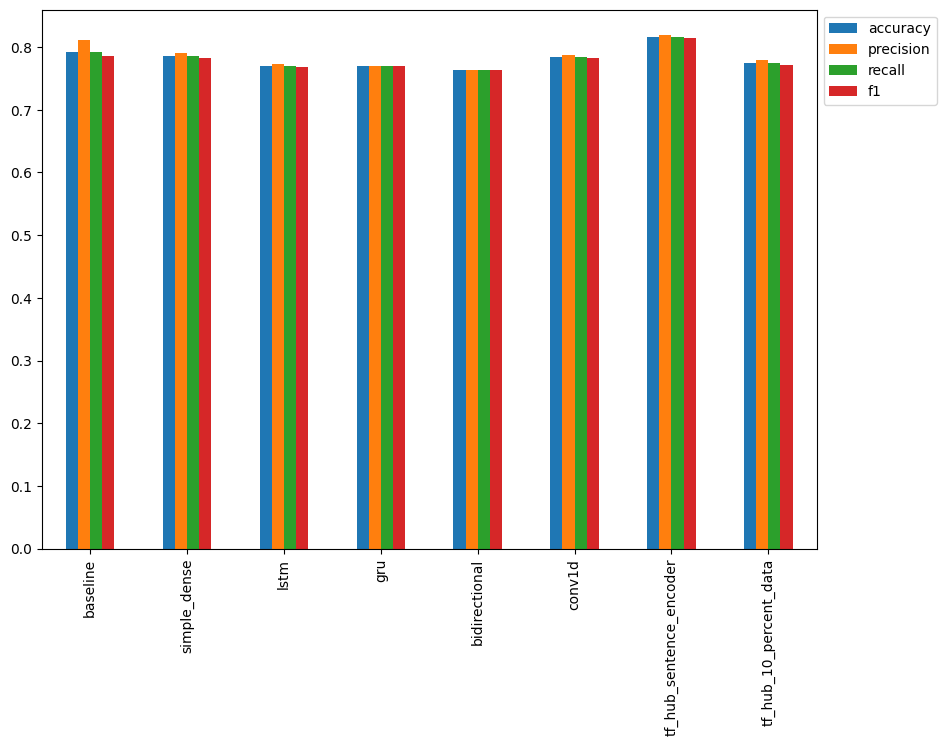

In [94]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

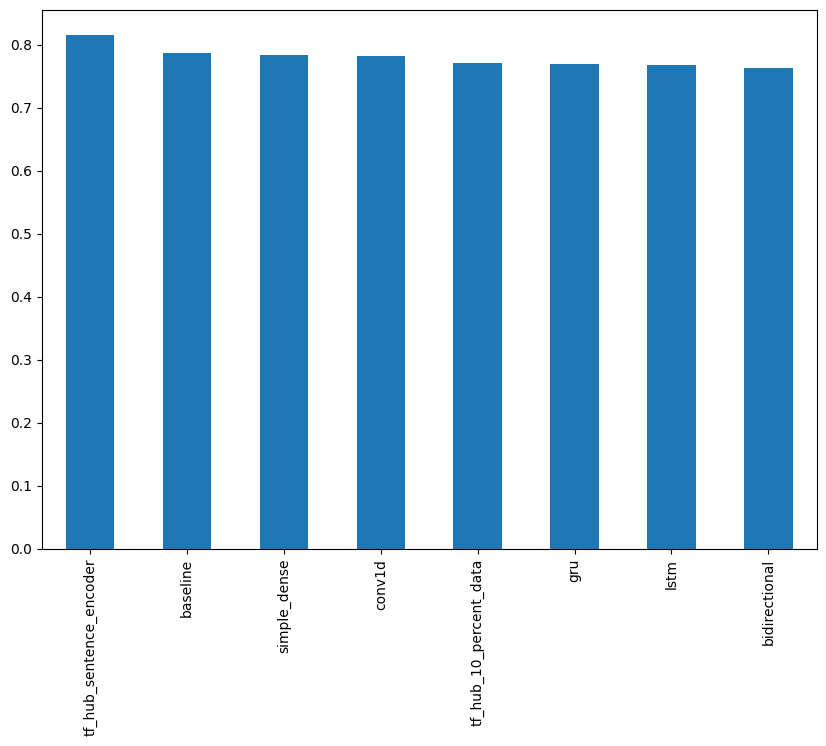

In [95]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

In [96]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [97]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 78.21522309711287,
 'precision': 0.7818857870038972,
 'recall': 0.7821522309711286,
 'f1': 0.7815779758842515}

In [98]:
# Add our combined model's results to the results DataFrame
all_model_results.loc["ensemble_results"] = ensemble_results

In [99]:
# Convert the accuracy to the same scale as the rest of the results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

In [100]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.786089,0.790328,0.786089,0.783297
lstm,0.770341,0.772634,0.770341,0.767924
gru,0.770341,0.770121,0.770341,0.769520
bidirectional,0.763780,0.763471,0.763780,0.762981
conv1d,0.784777,0.787357,0.784777,0.782576
tf_hub_sentence_encoder,0.816273,0.818755,0.816273,0.814709
tf_hub_10_percent_data,0.774278,0.779473,0.774278,0.770787
ensemble_results,0.782152,0.781886,0.782152,0.781578


In [101]:
#Finding the most wrong examples

# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.148634
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.752858
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.983178
3,@camilacabello97 Internally and externally scr...,1,0.0,0.183356
4,Radiation emergency #preparedness starts with ...,1,1.0,0.729536


In [102]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.908179
759,FedEx will no longer transport bioterror patho...,0,1.0,0.864141
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.836820
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.831570
628,@noah_anyname That's where the concentration c...,0,1.0,0.830426
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.812168
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.799283
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.791078
144,The Sound of Arson,0,1.0,0.781174
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.780193


In [103]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9081790447235107
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.8641411662101746
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.8368203043937683
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Prob: 0.8315702676773071
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Prob: 0.8304256796836853
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8121682405471802
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1, Pr

In [104]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.061230193823575974
Text:
@BoyInAHorsemask its a panda trapped in a dogs body

----

Target: 1, Pred: 0, Prob: 0.05778072029352188
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.05589141696691513
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.05492211505770683
Text:
VICTORINOX SWISS ARMY DATE WOMEN'S RUBBER MOP WATCH 241487 http://t.co/yFy3nkkcoH http://t.co/KNEhVvOHVK

----

Target: 1, Pred: 0, Prob: 0.05229749530553818
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.044022124260663986
Text:
I get to smoke my shit in peace

----

Target: 1, Pred: 0, Prob: 0.03980054333806038
Text:
Reddit Will 

**Making predictions on the test dataset**

In [105]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 38ms/step
Pred: 1, Prob: 0.5844312906265259
Text:
@asgharchohan86 @AdilGhumro 
There are floods in kpk because you guys couldn't build dams in 30 years you ruled.
Even for your own Thar

----

1/1 [==============================] - 0s 35ms/step
Pred: 0, Prob: 0.1253097951412201
Text:
Billionaire Mottas Try Getting Trapped Money Out of Venezuela - Bloomberg http://t.co/5JqMWaf6Vp

----

1/1 [==============================] - 0s 37ms/step
Pred: 1, Prob: 0.9521217942237854
Text:
VIDEO: 'We're picking up bodies from water': Rescuers are searching for hundreds of migrants in the Mediterran... http://t.co/XfS3pJhFh9

----

1/1 [==============================] - 0s 59ms/step
Pred: 1, Prob: 0.9224773645401001
Text:
@TheRealPBarry How much CO2 does an erupting volcano and bush fires raging put into the atmosphere? None of the believers mention this.

----

1/1 [==============================] - 0s 67ms/step
Pred: 0, Prob: 0.3090983033180237
Text:
@FoxNe